<a href="https://colab.research.google.com/github/jaypark-moloco/bigquery-integration-test/blob/main/workspaces/jay_park/Prod_Test_Data_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Guidelines for using this script:**

1. After you finish developing the TEST query, please check for any syntax and data output errors in BQ UI. Also, the TEST data output schema must match the PROD data output.
2. Once basics have been verified in BQ UI, please use this Colab script for data discrepancy check between TEST and PROD queries (Note: There is a row limit of 10 max if there is a discrepancy).
3. If no discrepancy is found, then file a PR to make changes in PROD.


In [13]:
# Import PyDrive and associated libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.cloud import bigquery
from google.colab import syntax
from oauth2client.client import GoogleCredentials
from datetime import datetime

In [14]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [15]:
client = bigquery.Client(project='focal-elf-631')

**Please store the test and prod table names and queries to the variables below:**

In [16]:
#@title Variable: prod_table_name & prod_query

# Optional: You can rename the table (default is `prod`)
prod_table_name = "prod"

prod_query = r"""
# Test Case: Non-empty and different number of rows in the test table
# This is the test query

WITH app_profile AS (
  SELECT *
 FROM `moloco-data-prod.insight_bank.app_profile`
)
SELECT app_profile.*
FROM
  app_profile,
  UNNEST(GENERATE_ARRAY(1, 10)) AS multiply_by_10
"""

In [17]:
#@title Variable: test_table_name & test_query

# Optional: You can rename the table (default is `test`)
test_table_name = "test"

test_query = r"""
# Test Case: Non-empty and different number of rows in the test table
# This is the prod query

SELECT *
FROM `moloco-data-prod.insight_bank.app_profile`
"""

**Below defines all the functions that will be used:**

In [18]:
#@title Function: run_query(query_str)
def run_query(query_str):
  """
  Executes query in BQ server and return result in dataframe form
  """

  return client.query(query_str).to_dataframe()

In [19]:
#@title Function: create_temp_tables(test_table_name, prod_table_name, test_query, prod_query)
def create_temp_tables(test_table_name, prod_table_name, test_query, prod_query, project_id, dataset_id):
  """
  Run PROD and TEST queries then store the results to temporary prod and test
  tables in `moloco-ods.ae_dev` dataset.
  """

  # Store query to create and store PROD results in temporary tables
  prod_query_table = f'''
  CREATE TABLE `{project_id}.{dataset_id}.{prod_table_name}`
  OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)
  )
  AS
  {prod_query}
  '''

  # Execute query in BQ server
  run_query(prod_query_table)


  # Store query to create and store TEST results in temporary tables
  test_query_table = f'''
  CREATE TABLE `{project_id}.{dataset_id}.{test_table_name}`
  OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)
  )
  AS
  {test_query}
  '''

  # Execute query in BQ server
  run_query(test_query_table)

In [20]:
#@title Function: check_discrepancy(test_table_name, prod_table_name)
def check_discrepancy(test_table_name, prod_table_name, project_id, dataset_id):
  """
  Check data between prod and test tables and return rows
  with discrepancies from eithr table.
  """

  compare_test_prod_query = f'''
  WITH test AS (
    SELECT *
    FROM `{project_id}.{dataset_id}.{test_table_name}`
  ), prod AS (
    SELECT *
    FROM `{project_id}.{dataset_id}.{prod_table_name}`
  )

  # Note: `duplicate_row` field is generated to be able to detect all duplicate
  # rows in either table as discrepancies.
  (SELECT *, ROW_NUMBER() OVER (PARTITION BY TO_JSON_STRING((SELECT AS STRUCT test.*))) AS duplicate_row
  FROM test
  EXCEPT DISTINCT
  SELECT *, ROW_NUMBER() OVER (PARTITION BY TO_JSON_STRING((SELECT AS STRUCT prod.*))) AS duplicate_row
  FROM prod)

  UNION DISTINCT

  (SELECT *, ROW_NUMBER() OVER (PARTITION BY TO_JSON_STRING((SELECT AS STRUCT prod.*))) AS duplicate_row
  FROM prod
  EXCEPT DISTINCT
  SELECT *, ROW_NUMBER() OVER (PARTITION BY TO_JSON_STRING((SELECT AS STRUCT test.*))) AS duplicate_row
  FROM test)
  '''

  result = run_query(compare_test_prod_query)

  return result

In [21]:
#@title Function: compare_test_prod_data(test_script_name, prod_script_name, test_table_name, prod_table_name)
def compare_test_prod_data(test_table_name, prod_table_name, test_query,
                           prod_query, project_id = "moloco-ods",
                           dataset_id = "ae_dev"):
  """
  Updates and compares test and prod tables to verify discrepancy before making
  changes to prod.

  Default project_id is `moloco-ods` and dataset id is `ae_dev`.
  """

  # Generate current datetime as string format to ensure uniqueness of temp
  # table names

  current_date_time = datetime.now()
  str_date_time = current_date_time.strftime("%Y_%m_%d_%H_%M_%S")

  test_table_name_unqiue = test_table_name + '_' + str_date_time
  prod_table_name_unqiue = prod_table_name + '_' + str_date_time

  # Create temporary tables
  create_temp_tables(test_table_name_unqiue, prod_table_name_unqiue, test_query, prod_query, project_id, dataset_id)

  print(f"Test Table Resource Name/Location: `{project_id}.{dataset_id}.{test_table_name_unqiue}`")
  print(f"\nProd Table Resource Name/Location: `{project_id}.{dataset_id}.{prod_table_name_unqiue}`")

  # Test data summary
  test_results_query = f'''
  SELECT *
  FROM `{project_id}.{dataset_id}.{test_table_name_unqiue}`
  '''

  test_results_df = run_query(test_results_query)

  print("\nTest Table Summary Statistics:")
  display(test_results_df.describe(include = 'all'))

  # Prod data summary
  prod_results_query = f'''
  SELECT *
  FROM `{project_id}.{dataset_id}.{prod_table_name_unqiue}`
  '''

  prod_results_df = run_query(prod_results_query)

  print("\nProd Table Summary Statistics:")
  display(prod_results_df.describe(include = 'all'))

  # Discrepancy data summary
  result_df = check_discrepancy(test_table_name_unqiue, prod_table_name_unqiue, project_id, dataset_id)

  if result_df.empty:
    print("\nThere is no discrepancy!")
  else:
    print("\n Discrepancy has been found for data shown below (limited to 10 max)")

    # Show basic output stats
    print("\nDiscrepancy Output Summary Statistics:")
    display(result_df.describe(include = 'all'))

    # Only show first 10 rows
    print("\nDiscrepancy Output:")
    return result_df.head(10)

In [22]:
# Run the script
compare_test_prod_data(test_table_name, prod_table_name, test_query, prod_query)

Test Table Resource Name/Location: `moloco-ods.ae_dev.test_2023_07_27_18_03_48`

Prod Table Resource Name/Location: `moloco-ods.ae_dev.prod_2023_07_27_18_03_48`

Test Table Summary Statistics:


,os,unified_publisher_name,publisher_name,publisher_id,app_name,app_id,app_release_month,publisher_country,publisher_region,genre,sub_genre,app_type,office,unified_app_id,advertiser_names,advertiser_display_names,is_hypercasual
count,161133,130260,154932,154932,154932,161133,63953,150244,149867,161133,82363,161133,149327,2714,5915,5915,161133
unique,2,17122,29702,31366,138729,161126,167,140,8,15,20,3,6,2138,2838,2797,2
top,ANDROID,AppLovin Corp,Lion Studios,292594310,Solitaire,1451295827,2020-09-01,USA,APAC,Others,Others,Game,EMEA,55d14e5514ba6706b3020e30,tiltingpoint,Tilting Point,False
freq,96258,668,323,267,39,2,1016,24801,73575,119172,55764,82383,45317,11,47,48,158002



Prod Table Summary Statistics:


,os,unified_publisher_name,publisher_name,publisher_id,app_name,app_id,app_release_month,publisher_country,publisher_region,genre,sub_genre,app_type,office,unified_app_id,advertiser_names,advertiser_display_names,is_hypercasual
count,1611330,1302600,1549320,1549320,1549320,1611330,639530,1502440,1498670,1611330,823630,1611330,1493270,27140,59150,59150,1611330
unique,2,17122,29702,31366,138729,161126,167,140,8,15,20,3,6,2138,2838,2797,2
top,ANDROID,AppLovin Corp,Lion Studios,292594310,Solitaire,com.fgs.spider.miami.man.ropehero.fighter,2020-09-01,USA,APAC,Others,Others,Game,EMEA,55d14e5514ba6706b3020e30,tiltingpoint,Tilting Point,False
freq,962580,6680,3230,2670,390,20,10160,248010,735750,1191720,557640,823830,453170,110,470,480,1580020



 Discrepancy has been found for data shown below (limited to 10 max)

Discrepancy Output Summary Statistics:


,os,unified_publisher_name,publisher_name,publisher_id,app_name,app_id,app_release_month,publisher_country,publisher_region,genre,sub_genre,app_type,office,unified_app_id,advertiser_names,advertiser_display_names,is_hypercasual,duplicate_row
count,1450197,1172340,1394388,1394388,1394388,1450197,575577,1352196,1348803,1450197,741267,1450197,1343943,24426,53235,53235,1450197,1450197.0
unique,2,17122,29702,31366,138729,161126,167,140,8,15,20,3,6,2138,2838,2797,2,<NA>
top,ANDROID,AppLovin Corp,Lion Studios,292594310,Solitaire,1451295827,2020-09-01,USA,APAC,Others,Others,Game,EMEA,55d14e5514ba6706b3020e30,tiltingpoint,Tilting Point,False,<NA>
freq,866322,6012,2907,2403,351,18,9144,223209,662175,1072548,501876,741447,407853,99,423,432,1422018,<NA>
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.58199
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0



Discrepancy Output:


,os,unified_publisher_name,publisher_name,publisher_id,app_name,app_id,app_release_month,publisher_country,publisher_region,genre,sub_genre,app_type,office,unified_app_id,advertiser_names,advertiser_display_names,is_hypercasual,duplicate_row
0,ANDROID,"Game Insight, LLC",Game Insight,Game Insight,Битва Стихий - match 3 RPG,com.gameinsight.battleandroid,2012-12-01,LTU,EMEA,Casual,Arcade,Game,EMEA,None,None,None,False,3
1,ANDROID,Playpark Company Limited,PLAYPARK,PLAYPARK,เซียนกระบี่สามภพ M,com.playpark.wildageaos,NaT,THA,APAC,Others,Others,Game,SGP,None,None,None,False,10
2,ANDROID,Pudlus Games,Pudlus Games,Pudlus Games,Motorbike Driving Simulator 3D,com.motorbike.driving.simulator,NaT,HUN,EMEA,Others,Others,Game,EMEA,None,None,None,False,2
3,ANDROID,WannaPlay LLC,WannaPlay LLC,WannaPlay LLC,Detected: читай комиксы и расследуй преступления,gg.detected,2021-05-01,BLR,EMEA,Casual,Others,Game,EMEA,None,None,None,False,10
4,ANDROID,ken.kafka,ken.kafka,ken.kafka,PepperU - people like pepper,com.indiann.pepperu,NaT,PHL,APAC,Others,None,Non-Game,SGP,None,None,None,False,9
5,ANDROID,None,DWP Fitness,DWP Fitness,DWP Fitness - Weight Loss with Diet & Workout ...,com.diet_and_workout_plan,NaT,ROU,EMEA,Others,None,Non-Game,EMEA,None,None,None,False,10
6,ANDROID,None,"Local Dating: Chat, Message, Flirt & Meet Apps","Local Dating: Chat, Message, Flirt & Meet Apps",Casual Dating app for singles,one.night.casual.secret.adult.singles.dating.m...,NaT,FIN,EMEA,Others,None,Non-Game,EMEA,None,None,None,False,8
7,ANDROID,None,Zoltán Pallagi,Zoltán Pallagi,SD Card Test Pro,com.pzolee.sdcardtesterpro,NaT,HUN,EMEA,Others,None,Non-Game,EMEA,None,None,None,False,4
8,IOS,Bart Bonte,Bart Bonte,568141787,yellow (game),1219259689,2017-05-01,BEL,EMEA,Casual,Puzzle,Game,EMEA,None,None,None,False,3
9,IOS,Bluebear Technologies Ltd.,Bluebear Technologies Ltd.,522548950,Hair Color Booth™,449512733,NaT,IRL,EMEA,Others,None,Non-Game,EMEA,None,None,None,False,10


Test cases

1. Different values for the same field in the test table ([link](https://www.diffchecker.com/iI8pvjyc/)).
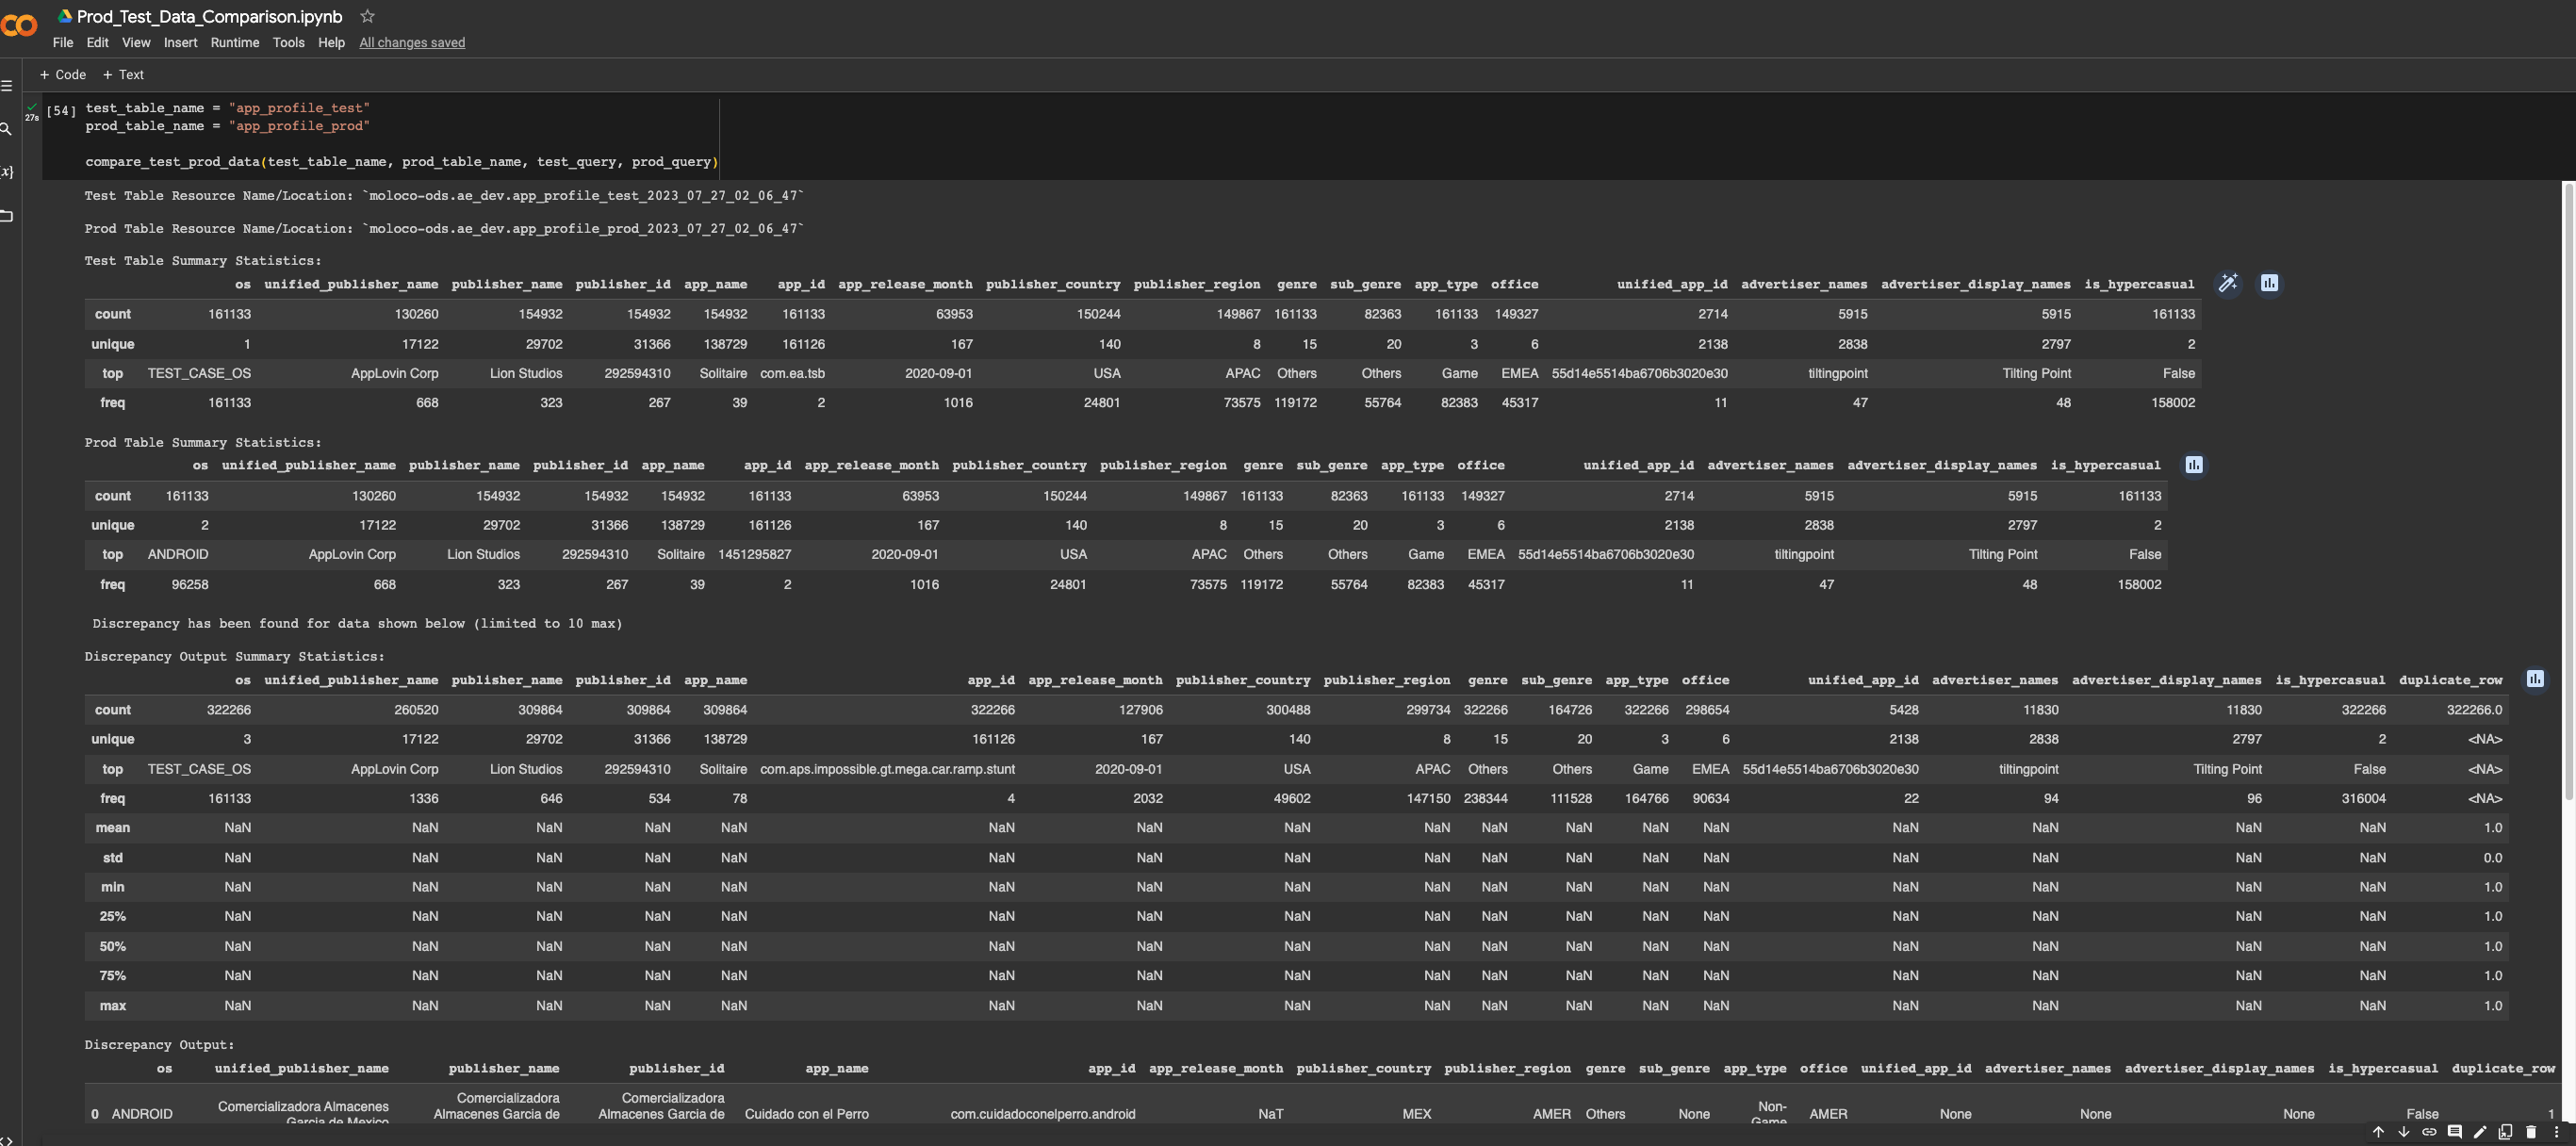

2. Different values for the same field in the prod table ([link](https://www.diffchecker.com/ZLggU62m/)).
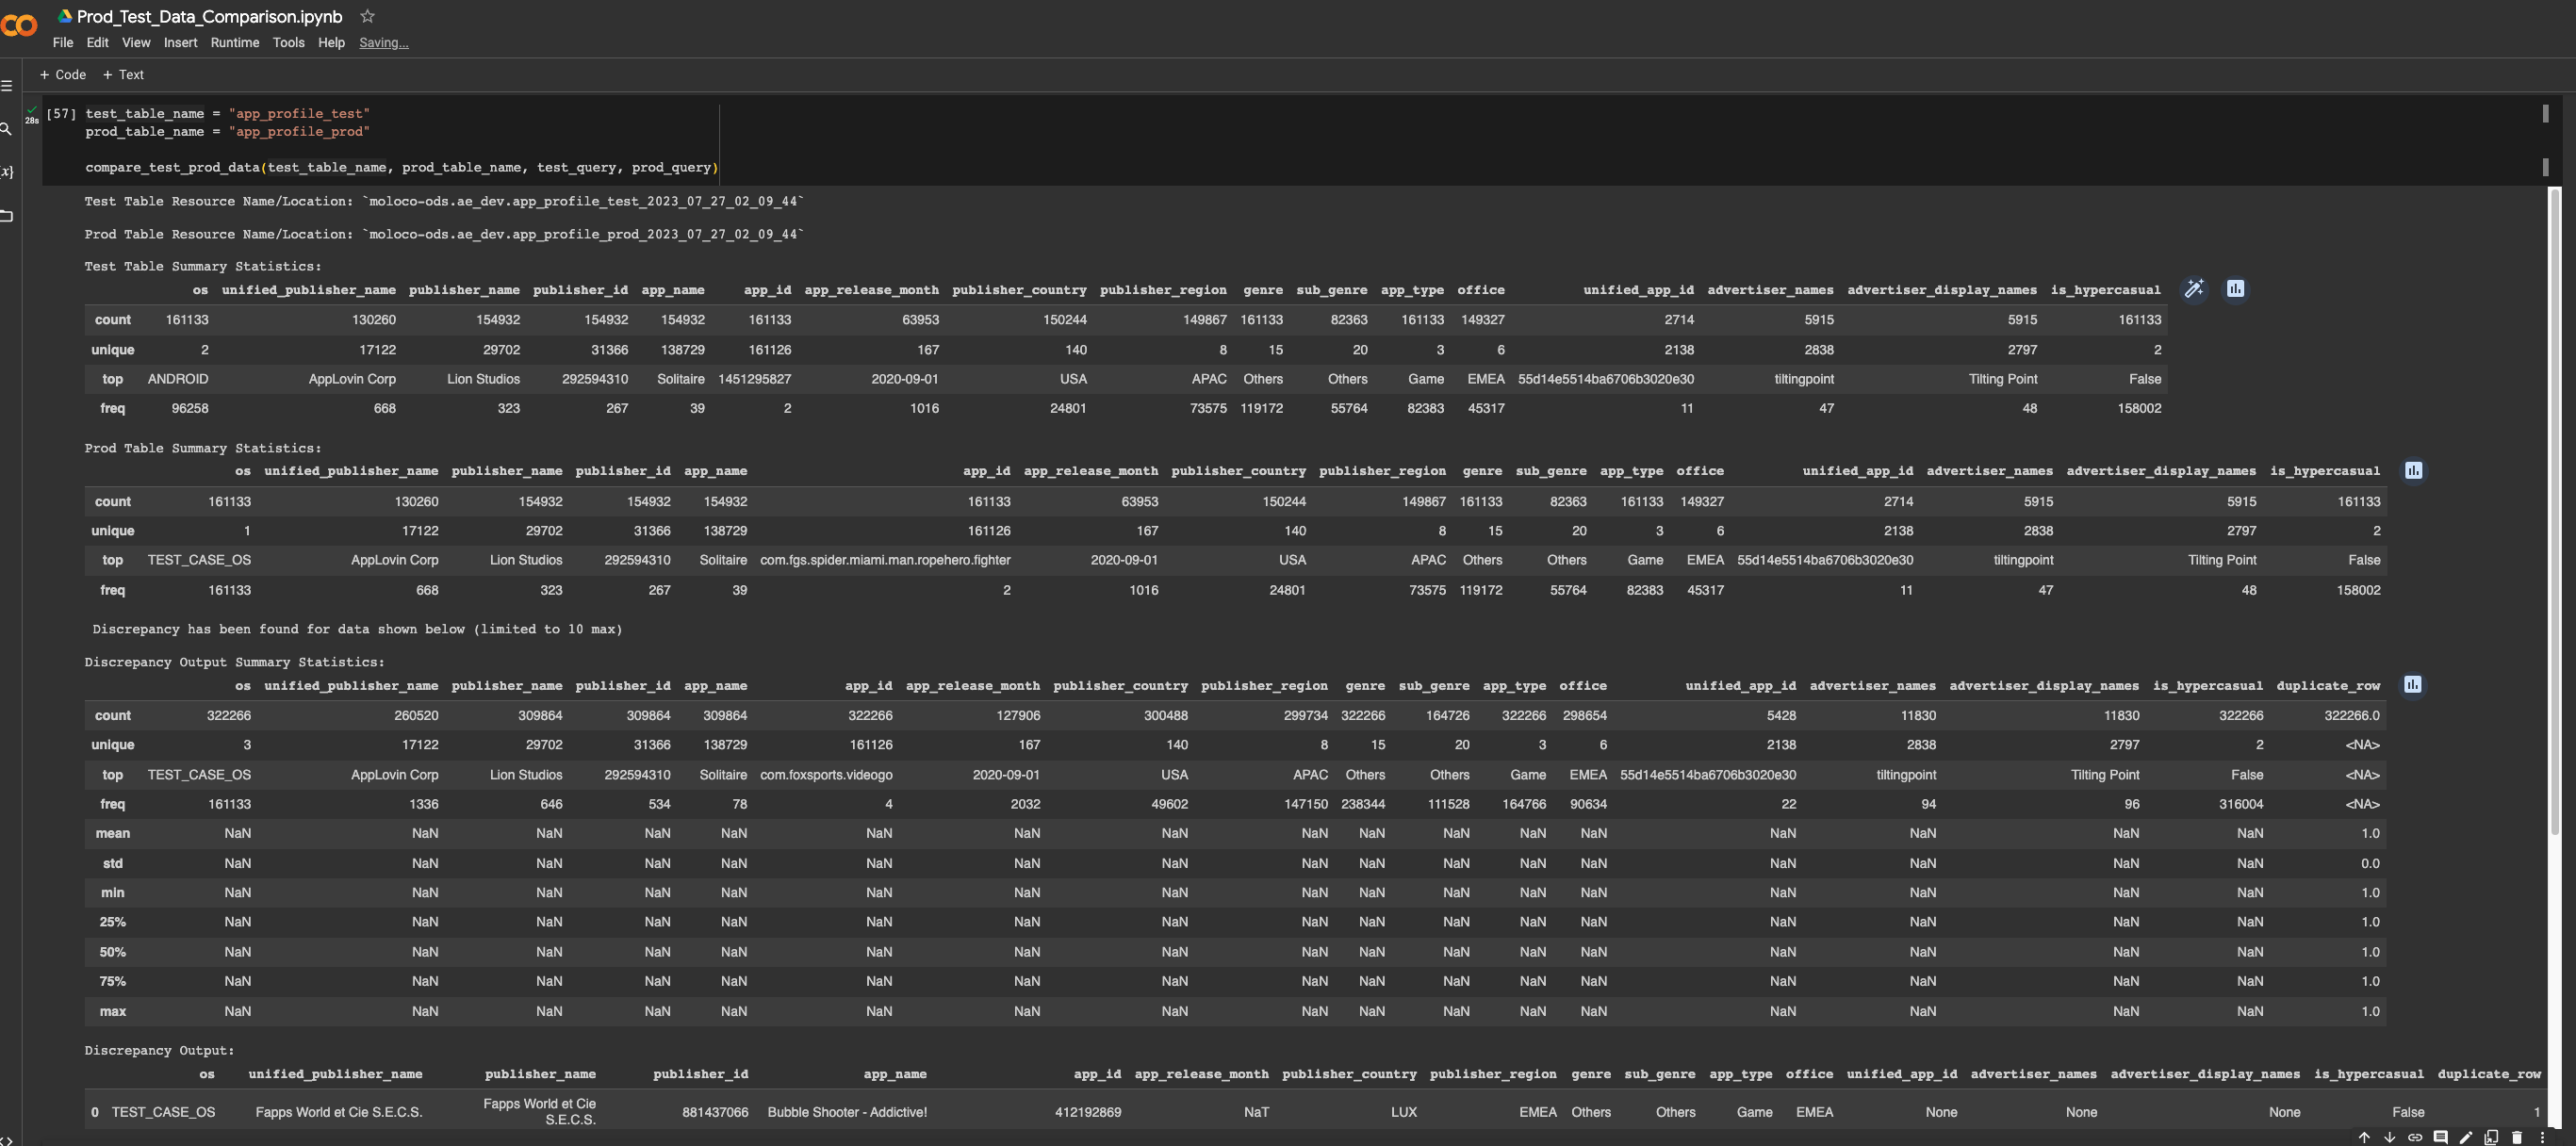

3. Empty data in the test table ([link](https://www.diffchecker.com/PKEwMWX4/)).
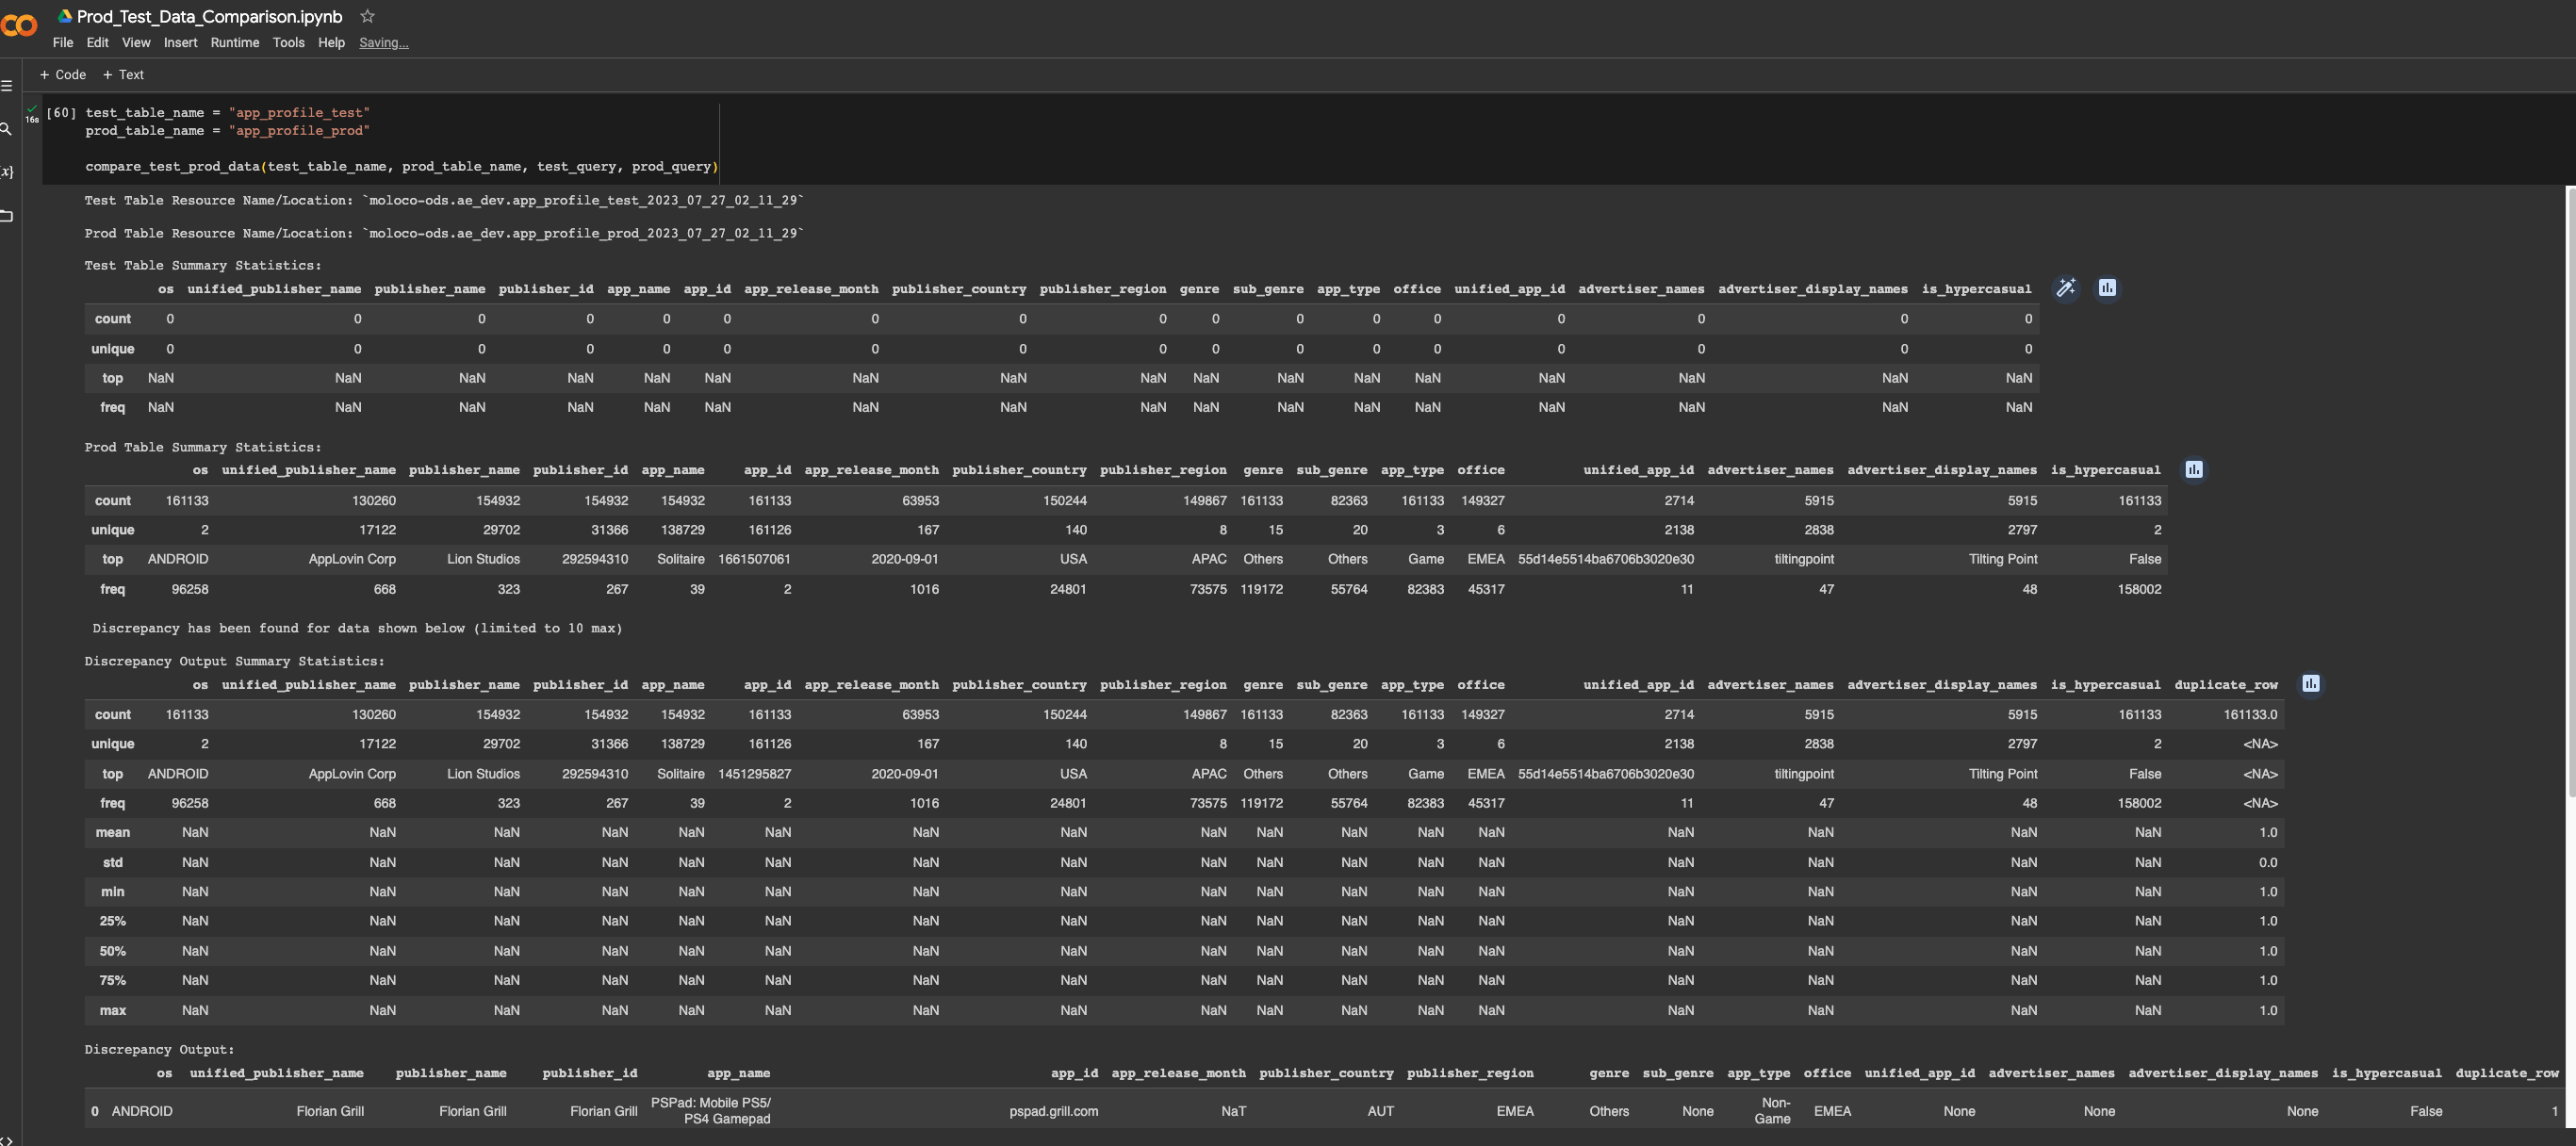

4. Empty data in the prod table ([link](https://www.diffchecker.com/8PJcHrrA/)).
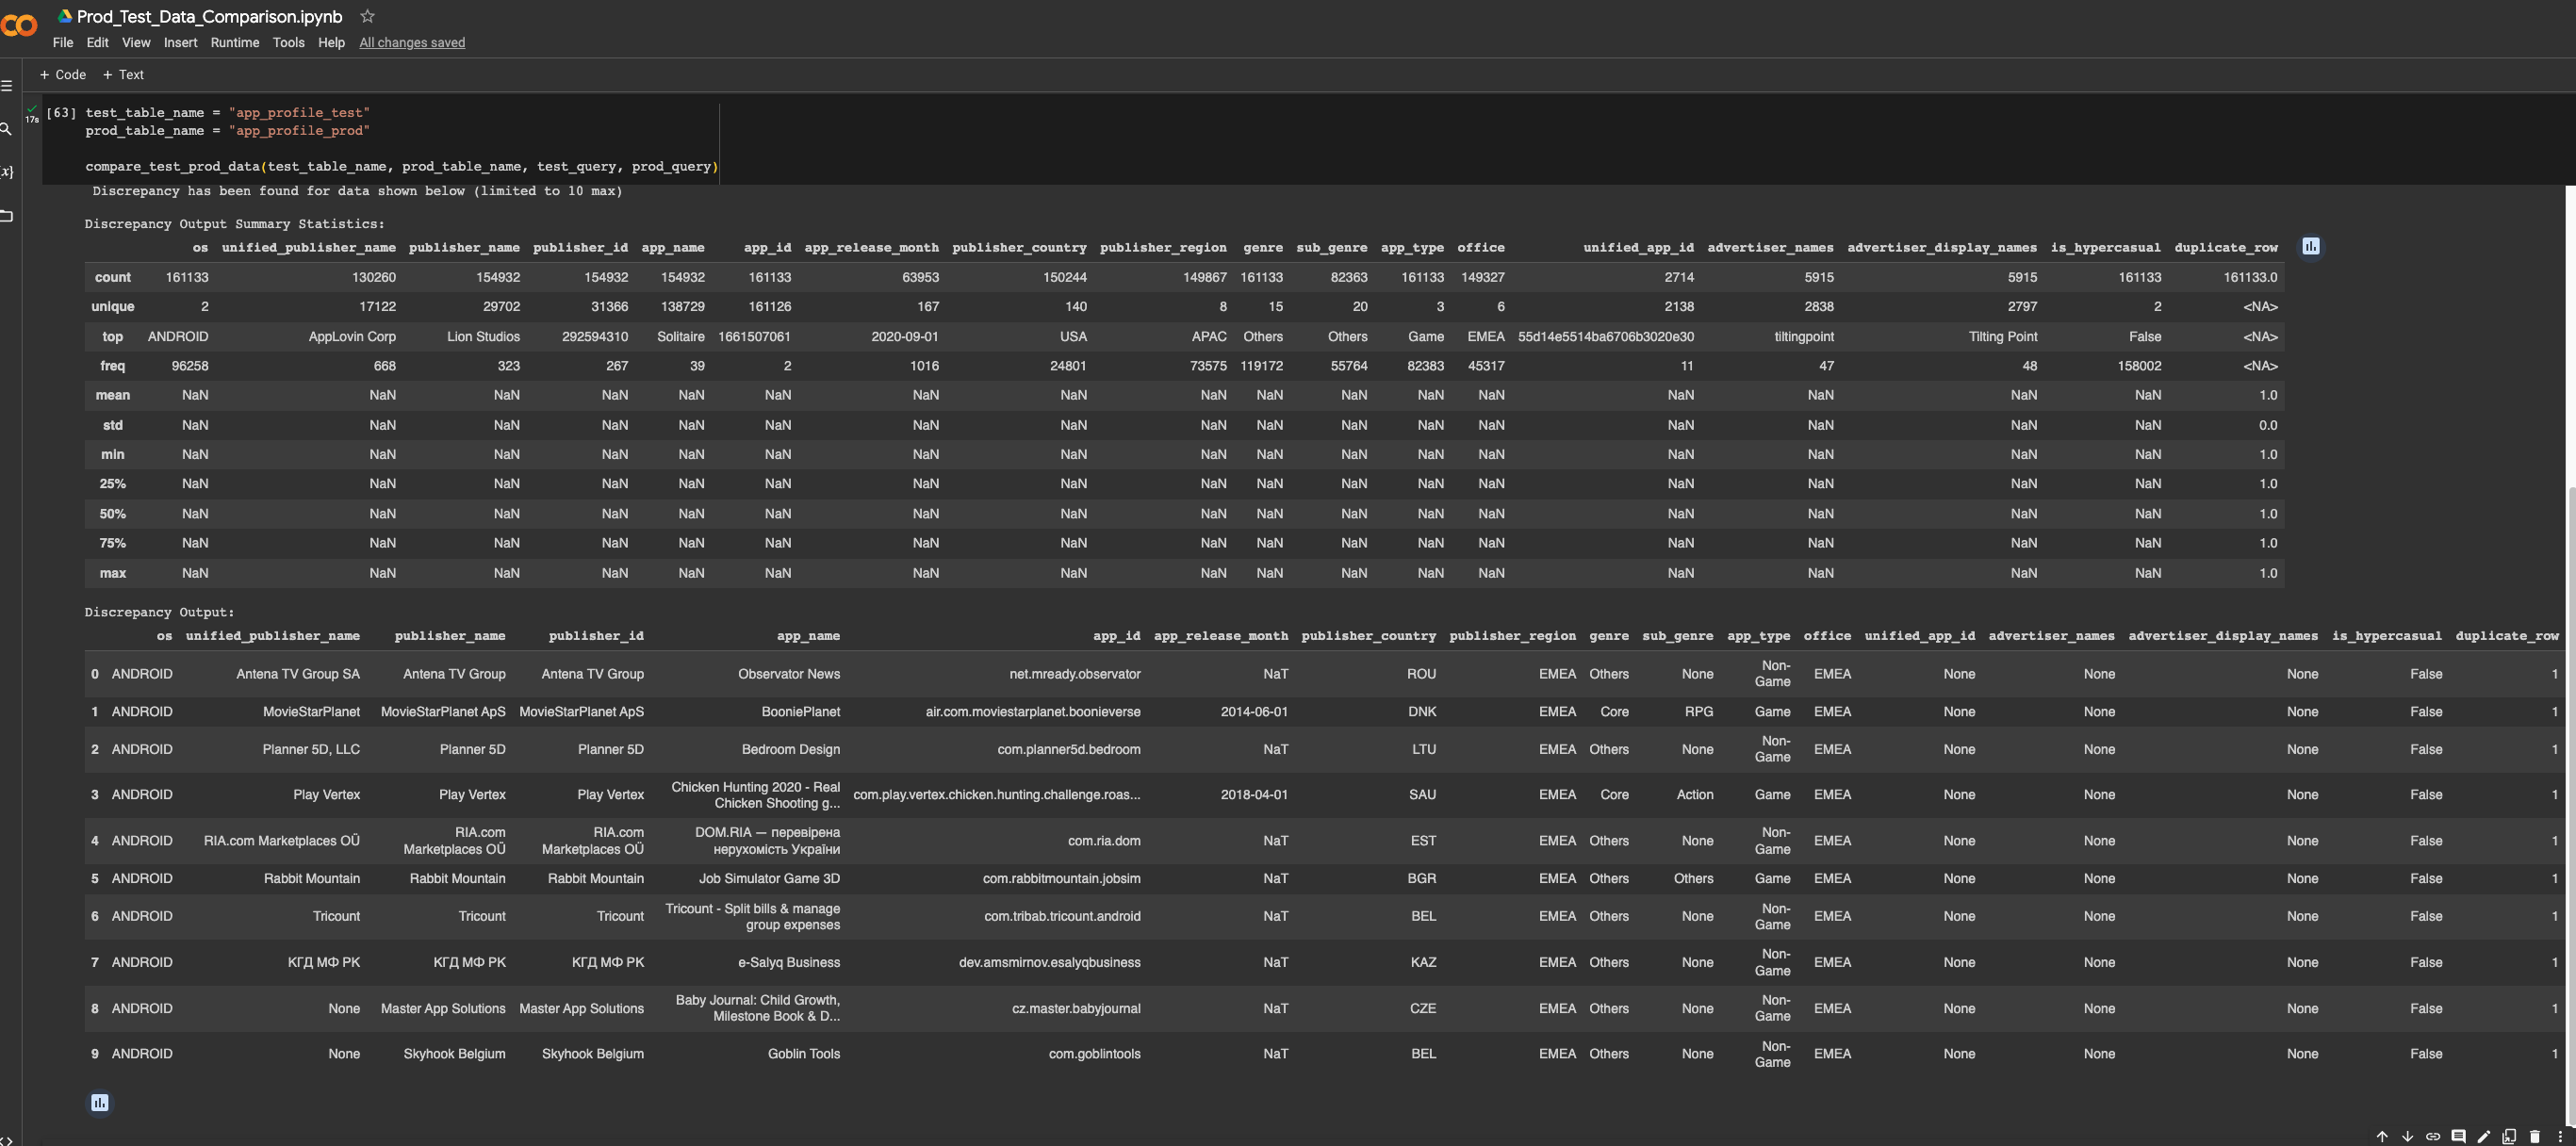

5. Non-empty and different number of rows in the test table - even duplicated entries ([link](https://www.diffchecker.com/5tb2Ku4m/)).
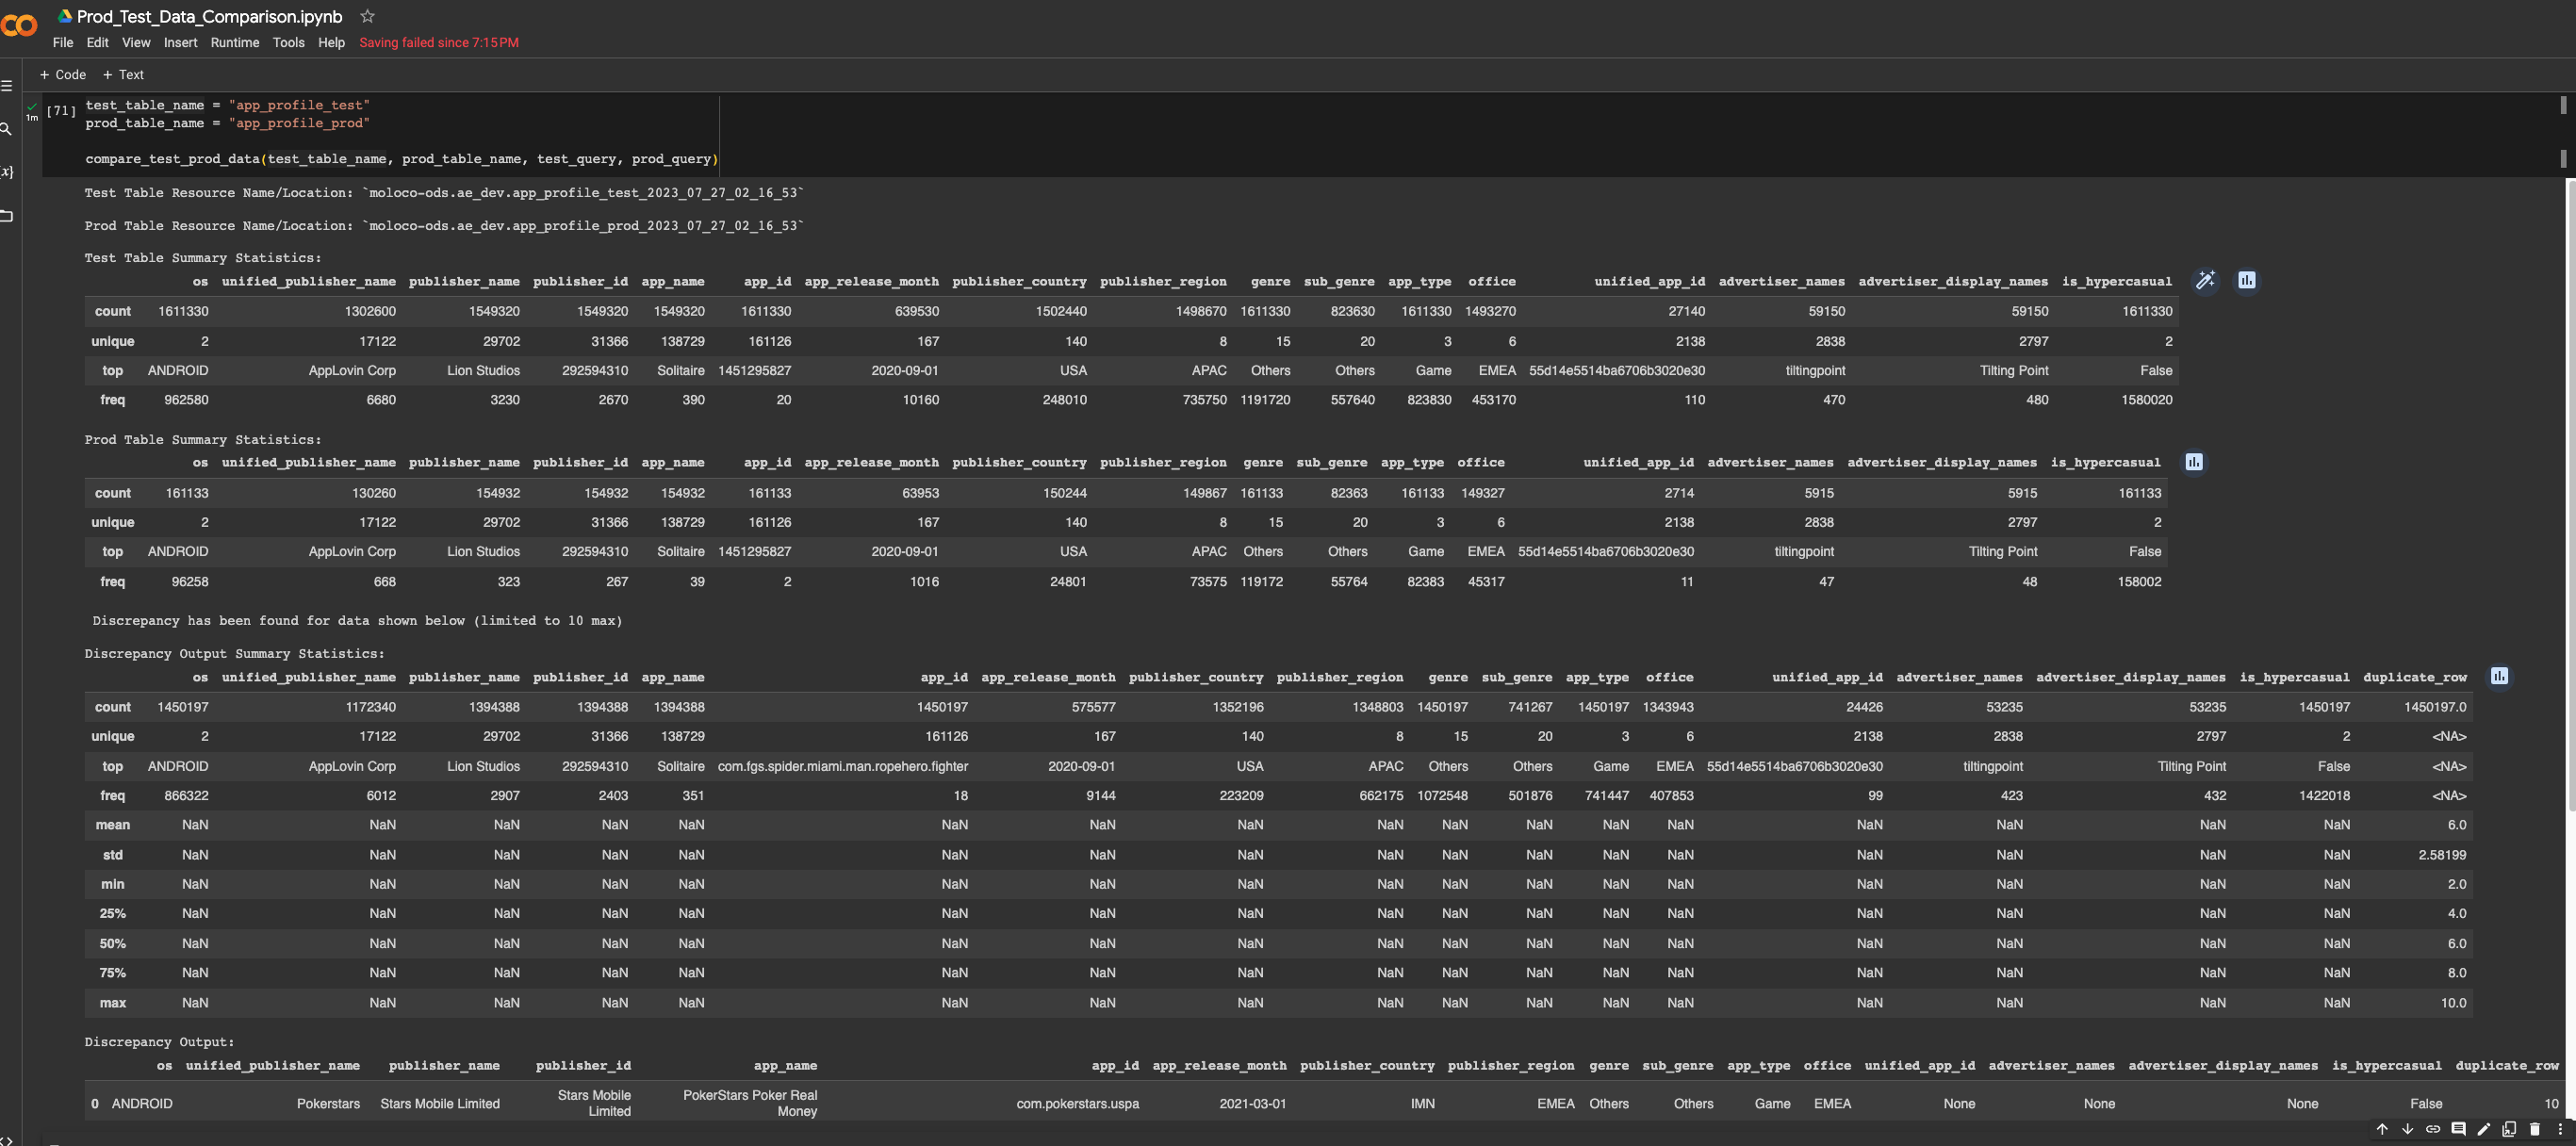

6. Non-empty and different number of rows in the prod table - even duplicated entries ([link](https://www.diffchecker.com/DJgmOCne/)).
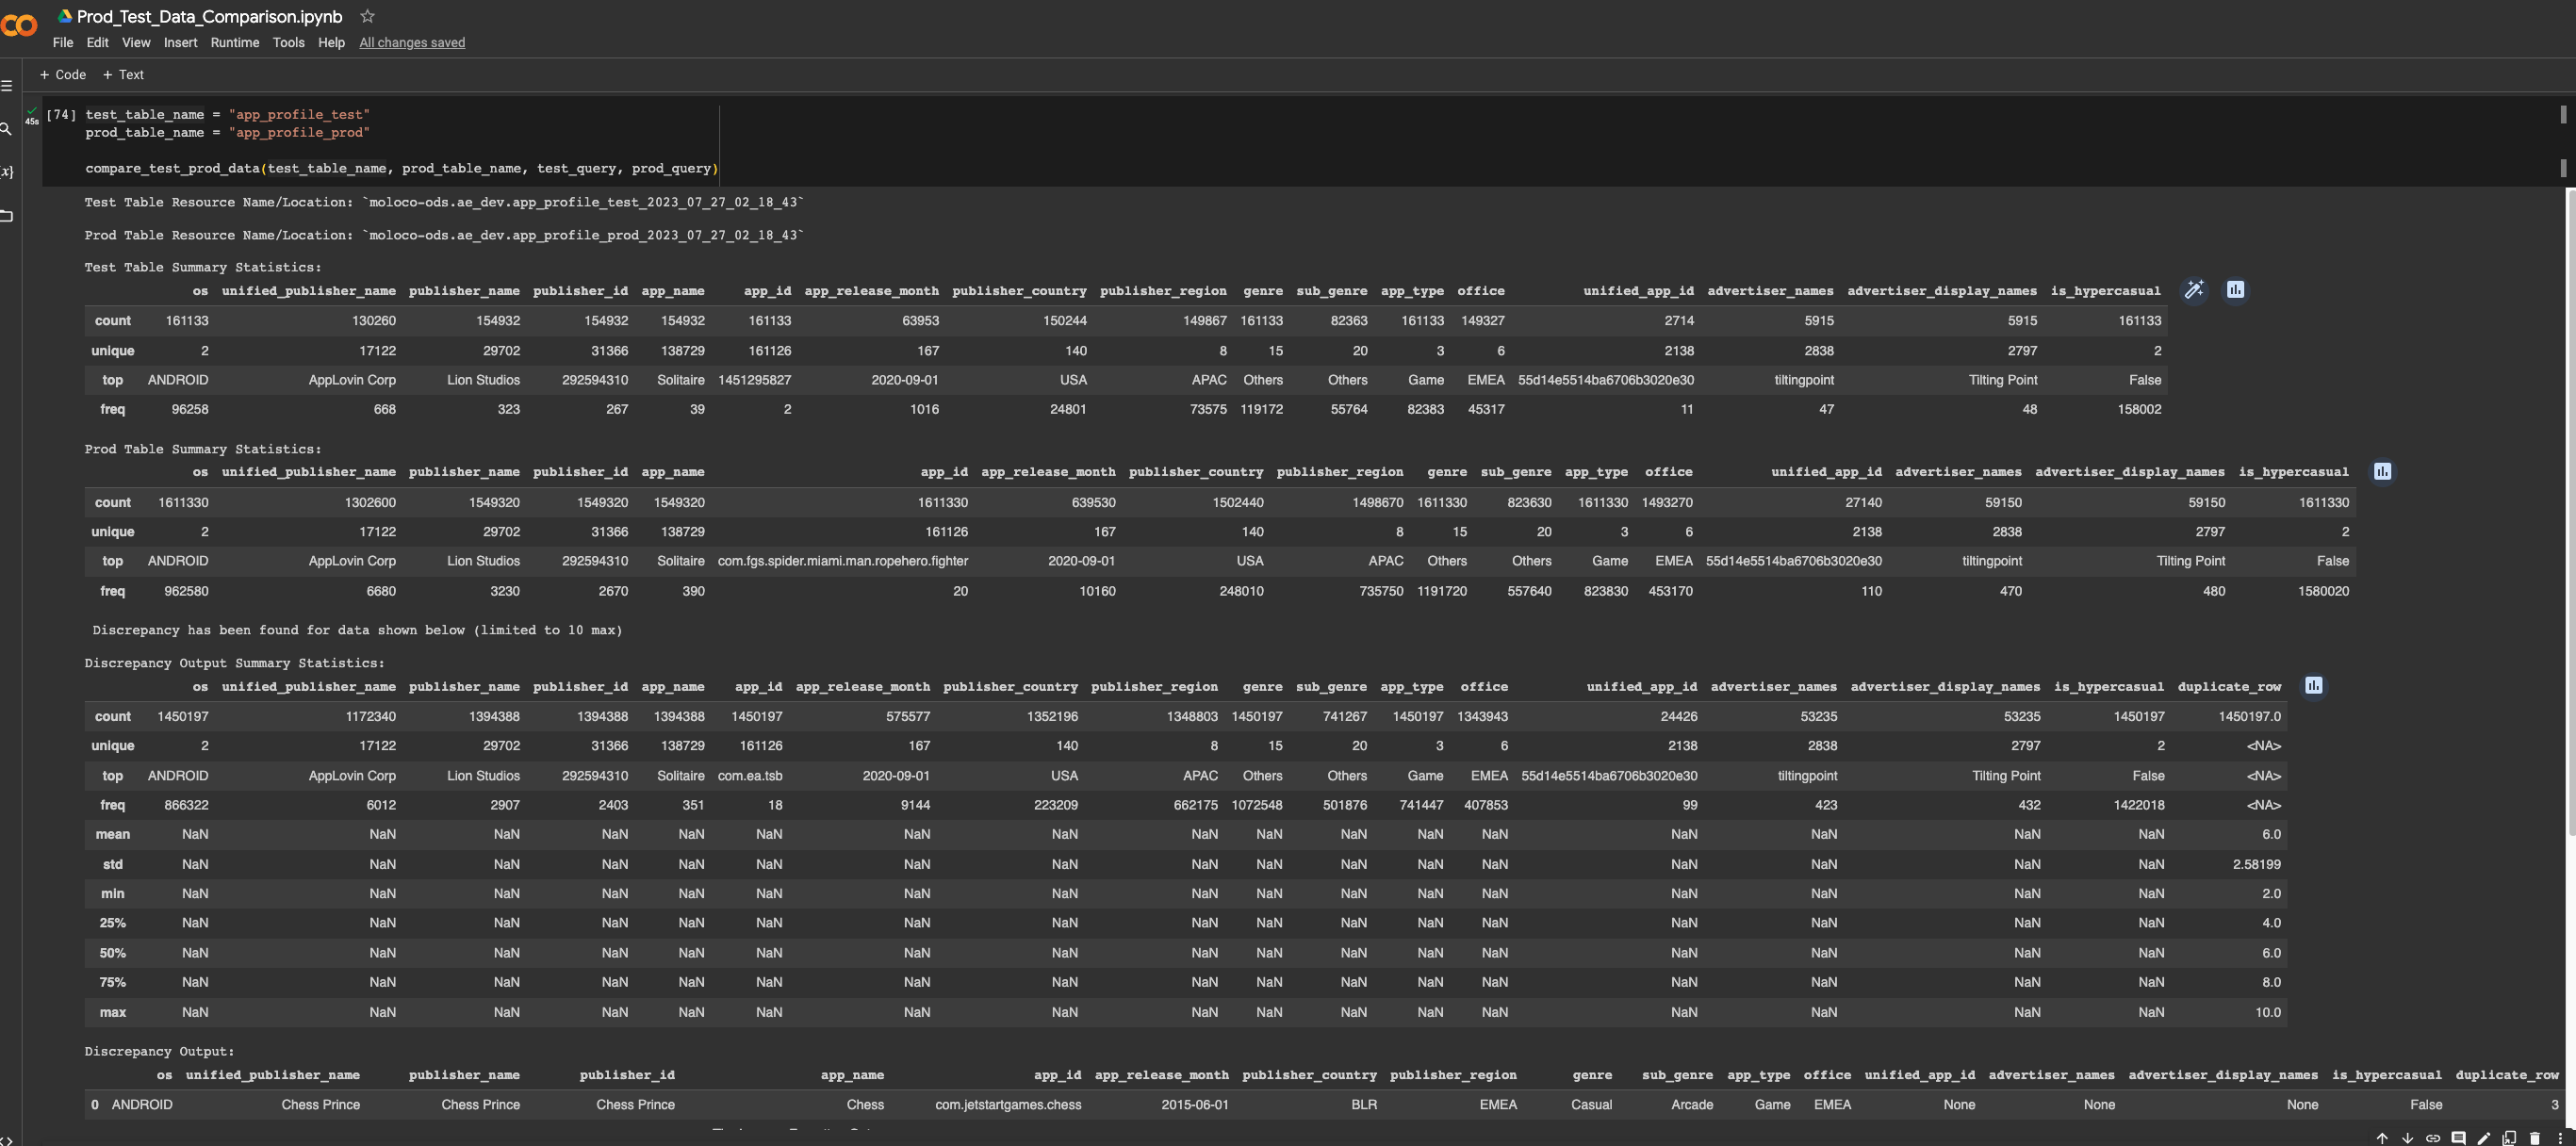